## Path Tracking

In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

Define Kinematic Model

In [2]:
class KinematicModel:

  def __init__(self, x, y, psi, v, L, dt):
    self.x = x
    self.y = y
    self.psi = psi
    self.v = v
    self.L = L # Distance between front and rear axles
    self.dt = dt  # discrete model

  def update_state(self, a, delta_f):
    self.x = self.x+self.v*math.cos(self.psi)*self.dt
    self.y = self.y+self.v*math.sin(self.psi)*self.dt
    self.psi = self.psi+self.v/self.L*math.tan(delta_f)*self.dt
    self.v = self.v+a*self.dt

  def get_state(self):
    return self.x, self.y, self.psi, self.v

PID Controller

In [3]:
class PID_posion:

    def __init__(self, kp, ki, kd, target, upper=1., lower=-1.):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.err = 0  # error
        self.err_last = 0 # previous error
        self.err_all = 0 # sum of error
        self.target = target
        self.upper = upper # upper bound of output
        self.lower = lower # lower bound of output
        self.value = 0

    def cal_output(self, state):
        self.err = self.target - state
        self.value = self.kp * self.err + self.ki * \
            self.err_all + self.kd * (self.err - self.err_last)
        self.update()
        return self.value

    def update(self):
        self.err_last = self.err
        self.err_all = self.err_all + self.err
        if self.value > self.upper:
            self.value = self.upper
        elif self.value < self.lower:
            self.value = self.lower

    def reset(self):
        self.err = 0
        self.err_last = 0
        self.err_all = 0

    def set_target(self, target):
        self.target = target


Path tracking

In [4]:
def path_tracking(refer_path,start_x,start_y,start_psi, speed):
    """
    Use PID controller to track the reference path
    
    attrs:
        refer_path (pandas DataFrame): a ideal path produced by path planning
        start_x(float): the start positon in x axis in pixcel coordinate system
        start_y(float): the start positon in y axis in pixcel coordinate system
        start_yaw(float): the start yaw angle of the tracktor
        speed(float): the speed of the tracktor
    returns:
        position (pandas DataFrame): a Pandas DF that contains the actual path the trackor takes
    """

    # Convert refer_path from DataFrame to NumPy array
    refer_path_np = refer_path #.to_numpy()

    # Initial state
    refer_tree = KDTree(refer_path_np) # reference trajectory for searching cloest track point
    x_ = []
    y_ = []
    L = 2
    time_step = 0.1
    tracktor = KinematicModel(start_x,start_y,start_psi,speed,L,time_step)
    PID = PID_posion(kp = 2, ki = 0.01, kd = 30, target=0, upper=np.pi/6, lower=-np.pi/6)

    for i in range(550):
        robot_state = np.zeros(2)
        robot_state[0] = tracktor.x
        robot_state[1] = tracktor.y
        distance, ind = refer_tree.query(robot_state)
        alpha = math.atan2(refer_path_np[ind, 1]-robot_state[1], refer_path_np[ind, 0]-robot_state[0])
        l_d = np.linalg.norm(refer_path_np[ind]-robot_state)
        theta_e = alpha-tracktor.psi
        e_y = -l_d*math.sin(theta_e)  
        delta_f = PID.cal_output(e_y)
        tracktor.update_state(0,delta_f) # accelaration = 0
        x_.append(tracktor.x)
        y_.append(tracktor.y)

    position = pd.DataFrame({
        'x': x_,
        'y': y_
    })

    # show the path tracking result
    plt.figure(1)
    plt.plot(refer_path_np[:, 0], refer_path_np[:, 1], '-.b', linewidth=1.0)
    plt.plot(x_,y_,'r')
    plt.xlabel('X')  
    plt.ylabel('Y') 
    plt.title('Path Tracking') 
    plt.show()
    
    return position

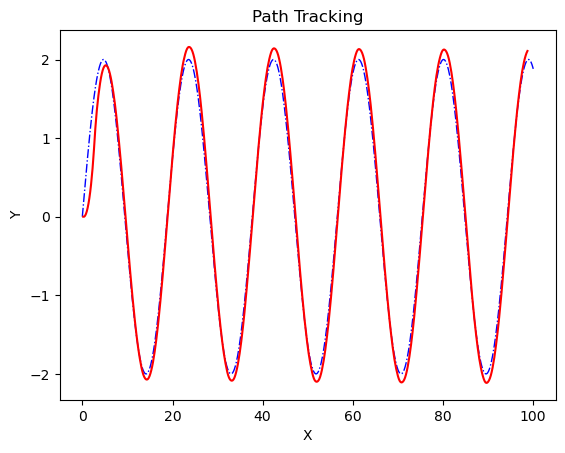

In [7]:
refer_path = np.zeros((1000, 2))
refer_path[:,0] = np.linspace(0, 100, 1000) 
refer_path[:,1] = 2*np.sin(refer_path[:,0]/3.0)
refer_tree = KDTree(refer_path) # reference trajectory for searching cloest track point
start_x = 0
start_y = 0
start_psi = 0
speed = 2

position = path_tracking(refer_path, start_x, start_y, start_psi,speed)